In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import save_video_from_images
import cv2

In [5]:
dataset_location = '../dataset/' # put the root or relative path to your dataset here

scene_df1 = pd.read_hdf(dataset_location + 'scene.hdf5')
scene_df2 = pd.read_hdf(dataset_location + 'scene2.hdf5')
scene_df3 = pd.read_hdf(dataset_location + 'scene3.hdf5')
car_scene_df1 = pd.read_hdf(dataset_location + 'car_scene.hdf5')
car_scene_df2 = pd.read_hdf(dataset_location + 'car_scene2.hdf5')
car_scene_df3 = pd.read_hdf(dataset_location + 'car_scene3.hdf5')

In [10]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros((x, y))
    weight = np.zeros((x, y))
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices

def pseud_calibration(arr, num_slices, reg= 100):
    slices = slice_array(arr, num_slices)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    original_means = [np.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s, reg) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [34]:
scene = np.stack(scene_df1["image"].values)
filter = pseud_calibration(scene, 32)
filtered_scene = scene - filter

(400, 15, 20)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


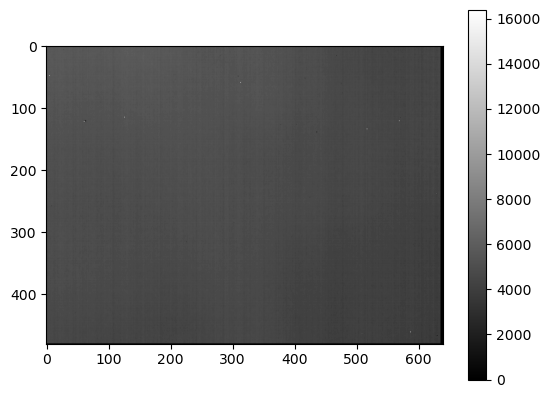

In [36]:
plt.imshow(filter, cmap='gray')
plt.colorbar()
plt.show()

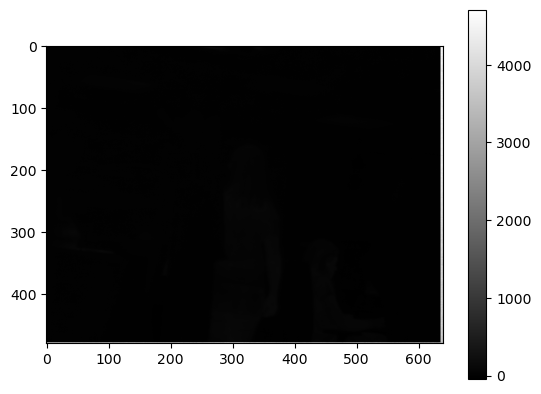

In [37]:
frame = (scene - (filter))[-15]
plt.imshow(frame, cmap='gray')
plt.colorbar()
plt.show()

In [15]:
all_vids = [scene_df1, scene_df2, scene_df3, car_scene_df1, car_scene_df2, car_scene_df3]
car_filter = pseud_calibration(np.stack(car_scene_df2["image"].values), 32)
scene_filter = pseud_calibration(np.stack(scene_df1["image"].values), 32)

for i, scene in enumerate(all_vids):
    location = "pseudo_calibration_blend/"
    name = f"scene{i+1}.avi" if i < 3 else f"car_scene{i-2}.avi"
    filter = scene_filter if i < 3 else car_filter
    scene = np.stack(scene["image"].values)
    filtered_scene = scene - filter
    save_video_from_images(filtered_scene, location + name)

(1001, 15, 20)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(400, 15, 20)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
